In [1]:
'''
#Gigacow-tools# - data collection for prolonged problematic cows.
This scripts used for single cow data collection work.
Data Tables: gigacow_filter.csv, lactation_filter.csv, traffic_raw_filter.csv
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, EfficientFCParameters, MinimalFCParameters
from tsfresh.feature_extraction.settings import from_columns
from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel, ExpSineSquared
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, log_loss

pd.options.mode.chained_assignment = None

#access data from local directory
dataDir = Path.cwd().parent.parent/'Data/processed'
gigacow_cols = ['Gigacow_Cow_Id', 'FarmName_Pseudo', 'BreedName', 'BirthDate']
lactation_cols = ['Gigacow_Cow_Id', 'FarmName_Pseudo', 'LactationInfoDate', 'LactationNumber', 'DaysInMilk']
gigacow = pd.read_csv(dataDir/'gigacow_filter.csv', encoding='utf-8', usecols=gigacow_cols)
lactation = pd.read_csv(dataDir/'lactation_filter.csv', encoding='utf-8', usecols=lactation_cols)
traffic = pd.read_csv(dataDir/'traffic_raw_filter.csv', encoding='utf-8', index_col=False)
#check out cows with most milking events
print(traffic.Gigacow_Cow_Id.value_counts().nlargest(10))

Gigacow_Cow_Id
5613    17247
4504    16330
5046    15623
5147    15440
3147    15303
478     14751
6380    14514
1181    14434
4478    14434
1985    14419
Name: count, dtype: int64


In [2]:
# Select cows with sufficient data points on single lactation periods
# Try to collect cow's data that contain milking events on lactation periods 1
# fetch all milking traffic events for merging
traffic_milking = traffic.TrafficResult.str.contains('kg', regex=False)
all_list = traffic_milking.index[traffic_milking.values == True].tolist()
milking_total = traffic[traffic.index.isin(all_list)]
milking_total.TrafficEventDateTime = pd.to_datetime(milking_total.TrafficEventDateTime)
milking_total['milking_date'] = milking_total.TrafficEventDateTime.dt.date

# convert data type
milking_total.milking_date = pd.to_datetime(milking_total.milking_date)
lactation.LactationInfoDate = pd.to_datetime(lactation.LactationInfoDate)
# merge all milking events with lactation table for filtering
milking_total = milking_total.merge(lactation, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'milking_date'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'LactationInfoDate'])

def lac_collect(NumLac, milking_total):
    """Generate cow list for multiple lactation periods.(30-60 DIM)

    Args:
        NumLac: The number of lactaion period
        milking_total: A dataframe contains all the milkings events

    Returns:
        A list contain all the cows events with sufficient data points within the lactation periods.
    """
    cow_list = list()
    for num in range(1, NumLac+1):
        # select records that contains lactation period #num
        milking_select1 = milking_total.loc[milking_total['LactationNumber'] == num]
        milking_select1.drop_duplicates(subset=['Gigacow_Cow_Id', 'milking_date', 'LactationNumber', 'DaysInMilk'], inplace=True)
        # drop the anomaly data point
        milking_select1 = milking_select1.loc[milking_select1.DaysInMilk < 40]
        # select sufficient data points on lactation 1
        selected1 = milking_select1.Gigacow_Cow_Id.value_counts(ascending=True)
        selected1 = selected1.loc[(selected1.values > 30) & (selected1.values < 40)]
        selected_cow_list = selected1.index.to_list()
        if num == 1:
            cow_list = selected_cow_list
        cow_list = list(set(cow_list) & set(selected_cow_list))
        print(len(cow_list), cow_list)
    return cow_list

#Calls lac_collect specifying that it will filter out rows with 30 < Days in milk <40 in lactation 1 and 2
cow_list = lac_collect(2, milking_total)
#cow_list = [3718, 2569, 1555, 5147, 1181, 926, 5160, 182, 5046, 1985, 1738, 74, 1103, 478, 5088, 5092, 2278, 6380, 2423, 3707]

159 [2560, 2568, 6153, 5645, 4109, 6164, 5147, 544, 3104, 1057, 550, 5160, 2090, 3629, 4142, 48, 571, 2112, 3657, 74, 3149, 6222, 1103, 4176, 2135, 1113, 5211, 603, 6241, 4195, 5225, 4714, 5235, 5239, 3705, 4730, 3200, 645, 3718, 5767, 3206, 2694, 3207, 5262, 2702, 151, 6300, 1181, 4765, 5279, 4769, 5284, 1705, 5301, 2742, 4792, 4280, 2746, 702, 708, 4295, 1738, 2251, 1744, 5844, 5846, 5848, 6361, 1755, 1244, 5852, 4318, 223, 2278, 2792, 3822, 5873, 4341, 2805, 5372, 1277, 769, 4358, 4871, 4362, 1812, 4374, 2844, 287, 289, 6434, 6439, 4910, 3887, 1842, 3890, 2868, 6452, 1331, 829, 6463, 2374, 4939, 5965, 2382, 2386, 342, 855, 856, 5465, 5978, 3422, 2409, 1393, 3441, 1905, 6004, 3446, 3447, 1910, 4988, 4990, 385, 6018, 3979, 3468, 2956, 6039, 2460, 5534, 3487, 2466, 2979, 4008, 4524, 4525, 4012, 943, 951, 1464, 1985, 4038, 2510, 978, 5076, 2517, 478, 5088, 5092, 3045, 3560, 3563, 3052, 5612, 6127, 5616, 1012, 507, 2047]
65 [2560, 769, 385, 6018, 3718, 5767, 2702, 151, 5147, 2844, 4765, 

In [3]:
def countCowAge(birthDate, milkingDate):
    '''
    func: Calculate cows age based on birthDate and milkingDate
    args: 
        birthDate: cow's birth datetime
        milkingDate: milking events datetime
    return: cow age in human years(float)
    '''
    birthDate = pd.to_datetime(birthDate)
    milkingDate = pd.to_datetime(milkingDate)
    days = np.float32(np.datetime64(milkingDate, 'D') - np.datetime64(birthDate, 'D'))
    age = np.around(days/365, 2)
    return age

    #select single cow from the traffic table

# select single cow from the traffic table

def data_collector(traffic, gigacow, lactation, cow_id, lacNumList):
    '''
    func: collect features from for a single cow
    args: 
        traffic: traffic data table
        gigacow: gigacow data table
        lactation: lactation data table
        cow_id: gigacow_id of the cow
        lacNumList: a list lactation period number
    return: A dataframe contains all features for a single cow on specfic lactation period
    '''

    traffic_single_cow = traffic.loc[traffic['Gigacow_Cow_Id'] == cow_id]
    traffic_single_cow.sort_values(by='TrafficEventDateTime', inplace=True)
    traffic_single_cow.index = range(len(traffic_single_cow))

    '''
        Extract Milking Event and its most recent traffic event to calculate T2-T1
        T1: Entry time into the Mjolkfalla
        T2: Entry time into the milking robot
        T2-T1: calculate time difference between T2&T1 (i.e., Time spend in Mjolkfalla/holding area)
    '''
    # locate mikling event by searching 'kg' keyword in traffic result
    # the most recent traffic event to milking event should be pre_milking event
    # need to filter out records with gate failure
    track_milking = traffic_single_cow.TrafficResult.str.contains('kg', regex=False)
    milking_index_list = track_milking.index[track_milking.values == True].tolist()
    pre_milking_index_list = [x-1 for x in milking_index_list]
    milking_traffic = traffic_single_cow[traffic_single_cow.index.isin(milking_index_list)]
    pre_milking_traffic = traffic_single_cow[traffic_single_cow.index.isin(pre_milking_index_list)]

    # drop rows that the gate failed to detect cows but have milking result
    # previous area in milking_traffic table should only be Mjolkfalla
    # previous area in pre_milking_traffic table should not be Mjolkfalla
    failed_list_1_milk = milking_traffic.index[milking_traffic['PreviousArea'] == 'Koridor till Sorteringsgrind 2'].tolist()
    failed_list_1_pre = [x-1 for x in failed_list_1_milk]
    failed_list_2_pre = pre_milking_traffic.index[pre_milking_traffic['PreviousArea'] == 'Mjolkfalla'].tolist()
    failed_list_2_milk = [x+1 for x in failed_list_2_pre]
    # traffic result in pre_milking_traffic table should contain Mjolkfalla
    track_pre_milking = pre_milking_traffic.TrafficResult.str.contains('Mjolkfalla', regex=False)
    failed_list_3_pre = track_pre_milking.index[track_pre_milking.values == False].tolist()
    failed_list_3_milk = [x+1 for x in failed_list_3_pre]

    # remove failed records based on index list
    milking_traffic_failed = failed_list_1_milk + failed_list_2_milk + failed_list_3_milk
    pre_milking_traffic_failed = failed_list_1_pre + failed_list_2_pre + failed_list_3_pre
    milking_traffic.drop(axis=0, index=milking_traffic_failed, inplace=True)
    pre_milking_traffic.drop(axis=0, index=pre_milking_traffic_failed, inplace=True)
    # concatenate two tables to track the traffic directly
    all_milking_traffic = pd.concat([milking_traffic, pre_milking_traffic])
    all_milking_traffic.sort_values(by=['TrafficEventDateTime'], inplace=True)
    #rename table columns for merging
    milking_traffic.rename(columns={"TrafficEventDateTime": "MilkingEventDateTime", "TrafficResult": "MilkProduction", "TimeInArea_totalSeconds": "RoundedSecondsTimeInArea"}, inplace=True)
    pre_milking_traffic.rename(columns={"TrafficEventDateTime": "Pre_MilkingEventDateTime", "TimeInArea_totalSeconds": "RoundedSecondsTimeInArea"}, inplace=True)
    # unify the index of two tables
    milking_traffic.index = range(len(milking_traffic))
    pre_milking_traffic.index = range(len(pre_milking_traffic))
    # inert "pre_traffic_milking" to milking traffic table
    milking_traffic.insert(5, 'Pre_MilkingEventDateTime', pre_milking_traffic['Pre_MilkingEventDateTime'])
    # calculate T2-T1
    milking_traffic.MilkingEventDateTime = pd.to_datetime(milking_traffic.MilkingEventDateTime)
    milking_traffic.Pre_MilkingEventDateTime = pd.to_datetime(milking_traffic.Pre_MilkingEventDateTime)
    milking_traffic['timeDelta_Seconds'] = (milking_traffic['MilkingEventDateTime'] - milking_traffic['Pre_MilkingEventDateTime']).dt.total_seconds()

    # extract traffic result(milk production)
    milking_traffic['MilkProduction'].replace(r"[^0-9.,]+"," ", inplace=True, regex=True)
    milking_traffic['MilkProduction'].replace(r"\s*","", inplace=True, regex=True)
    milking_traffic['MilkProduction'].replace(r"[,]+",".", inplace=True, regex=True)
    milking_traffic['MilkProduction'] = milking_traffic['MilkProduction'].astype('float64')

    # merge all the other features into milking_traffic table
    milking_traffic['MilkingDate'] = milking_traffic.MilkingEventDateTime.dt.date
    milking_traffic.MilkingDate = pd.to_datetime(milking_traffic.MilkingDate)
    lactation.LactationInfoDate = pd.to_datetime(lactation.LactationInfoDate)
    single_cow_merge = milking_traffic.merge(lactation, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'MilkingDate'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'LactationInfoDate'])
    single_cow_merge = single_cow_merge.merge(gigacow, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id'])

    # drop failed data points based on RoundedSecondsTimeInArea & timeDelta_Seconds
    single_cow_merge.drop(single_cow_merge.loc[abs(single_cow_merge.timeDelta_Seconds - single_cow_merge.RoundedSecondsTimeInArea) > 300].index, inplace=True)
    single_cow_merge['TrafficDeviceName'].replace(r"[A-Za-z]+\s*","vms", inplace=True, regex=True)
    # calculate age of cows
    single_cow_merge['Age'] = single_cow_merge.apply(lambda x: countCowAge(x['BirthDate'], x['MilkingEventDateTime']), axis=1)
    single_cow_merge.drop(['BirthDate'], axis=1, inplace=True)
    single_cow_merge.dropna(inplace=True)

    # integrate multiple milking events for a single DIM
    single_cow_merge = single_cow_merge[single_cow_merge.LactationNumber.isin(lacNumList)]
    single_cow_merge.index = range(1,len(single_cow_merge)+1) 
    single_cow_merge.drop(['MilkingEventDateTime', 'Pre_MilkingEventDateTime', 'Traffic_Id', 'MilkingInterval_totalSeconds', 'RoundedSecondsTimeInArea', 'PreviousArea', 'GroupName', 'LactationInfoDate', 'TrafficDeviceName'], axis=1, inplace=True)

    comb_cows = single_cow_merge.groupby(by=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'MilkingDate', 'LactationNumber', 'DaysInMilk', 'BreedName', 'Age'], sort=False, as_index=False).sum(['MilkProduction', 'timeDelta_Seconds'])
    single_cow_merge_size = single_cow_merge.groupby(by=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'MilkingDate', 'LactationNumber', 'DaysInMilk', 'BreedName', 'Age'], sort=False, as_index=False).size()
    comb_cows = pd.concat([comb_cows, single_cow_merge_size['size']], axis=1, ignore_index=False)
    comb_cows.rename(columns={"MilkProduction": "Total_MilkProduction", "timeDelta_Seconds": "Total_timeDelta_Seconds", "size": "milking_times"}, inplace=True)
    comb_cows.index = range(1, len(comb_cows)+1)
    return comb_cows

In [4]:
periods = [1, 2]
# fetch enough data points from lactation period 1&2
# mean_totalTimeCost_1 = 0
# mean_totalTimeCost_2 = 0
Path(dataDir/'prolonged_problematic_targetCows').mkdir(parents=True, exist_ok=True)
for p in periods:
    Path(dataDir/'prolonged_problematic_targetCows'/str(p)).mkdir(parents=True, exist_ok=True)


# save target cows tables to directory
for i, cow_id in enumerate(cow_list):
    for p in periods:
        single_cow_merge = data_collector(traffic, gigacow, lactation, cow_id, [p])
        single_cow_merge = single_cow_merge.loc[(single_cow_merge.DaysInMilk < 40)]

        single_cow_merge["id"] = i+1
        # Check if the DataFrame has rows before saving
        fileName = 'prolonged_problematic_targetCows/' + str(p) + '/cow_' + str(i) + '.csv'
        single_cow_merge.to_csv(dataDir/fileName)
    #fileName = 'memory_targetCows/cow_' + str(i) + '.csv'
    #single_cow_merge.to_csv(dataDir/fileName, index=False)
        
print("num of cows: ", len(cow_list))
# print("Mean of total time cost at lactation period 1: ", mean_totalTimeCost_1/len(cow_list))
# print("Mean of total time cost at lactation period 2: ", mean_totalTimeCost_2/len(cow_list))

num of cows:  65


In [5]:
""" Data Preparation """

dataDir = Path.cwd().parent.parent/'Data/processed/prolonged_problematic_targetCows/'
usecols = ['id', 'FarmName_Pseudo', 'Gigacow_Cow_Id', 'Total_MilkProduction', 'Total_timeDelta_Seconds', 'LactationNumber', 'DaysInMilk', 'BreedName', 'Age', 'milking_times', 'MilkingDate']

# labeling cow with prolonged problematic behavior(1/0)
def labeling_memory(threshold_percentage, cow_l1, cow_l2): 
    '''
    func: labeling prolonged problematic dataset
    args: 
        threshold_percentage: threshold for the ratio of milking time cost reduction
        cow_l1: A dataframe contains all data points for a single cow on lactation period 1
        cow_l2: A dataframe contains all data points for a single cow on lactation period 2
    return: prolonged problematic dataset with label
    '''
    global prob
    total_timeCost_1 = 0
    total_timeCost_2 = 0
    # lactation period 1
    total_timeCost_1 = cow_l1.Total_timeDelta_Seconds.sum()
    totalEvents_1 = cow_l1.milking_times.sum()
    mean_timeCost_1 = total_timeCost_1/totalEvents_1
    # lactation period 2
    total_timeCost_2 = cow_l2.Total_timeDelta_Seconds.sum()
    totalEvents_2 = cow_l2.milking_times.sum()
    mean_timeCost_2 = total_timeCost_2/totalEvents_2
    time_diff = (mean_timeCost_1-mean_timeCost_2)/mean_timeCost_1
    # print("cow: " + str(time_diff))
    # print(mean_timeCost_1)
    # print(mean_timeCost_2)
    
    # anomalies detection
    if time_diff < 0.1:
        print(cow_l1.FarmName_Pseudo.unique())
        print(time_diff)
        prob = 2
        return prob
    print(time_diff)
    if time_diff > threshold_percentage:
        prob = 1 # normal behavior
        print("normal behavior")
    else:
        prob = 0 # exist prolonged problematic behavior
        print("prolonged problematic behavior")
    return prob


In [6]:
# periods = os.listdir(dataDir)
periods = [1, 2]

filelist = list(Path(dataDir/'1').glob('*.csv'))

# integrate all the cows data into one dataset
for i, _ in enumerate(filelist):
    fileName = 'cow_' + str(i) + '.csv'
    single_cow_1 = pd.read_csv(dataDir/'1'/fileName, encoding='utf-8', usecols=usecols)
    single_cow_2 = pd.read_csv(dataDir/'2'/fileName, encoding='utf-8', usecols=usecols)
    single_cow_1.sort_values(by=['MilkingDate'], inplace=True)
    single_cow_2.sort_values(by=['MilkingDate'], inplace=True)
    print(i)
    label = labeling_memory(0.65, single_cow_1, single_cow_2)
    # skip anomalies
    if label == 2:
        continue
    single_cow = pd.concat([single_cow_1, single_cow_2], axis=0, ignore_index=True)
    single_cow['label'] = label
    if i == 0:
        cow_total = single_cow
        cow_total_1 = single_cow_1
        cow_total_2 = single_cow_2
    else:
        cow_total = pd.concat([cow_total, single_cow], axis=0, ignore_index=True)
        cow_total_1 = pd.concat([cow_total_1, single_cow_1], axis=0, ignore_index=True)
        cow_total_2 = pd.concat([cow_total_2, single_cow_2], axis=0, ignore_index=True)

# add extra columns for mean_Total_timeDelta_Seconds
cow_total_1["mean_Total_timeDelta_Seconds"] = cow_total_1.Total_timeDelta_Seconds/cow_total_1.milking_times
cow_total_2["mean_Total_timeDelta_Seconds"] = cow_total_2.Total_timeDelta_Seconds/cow_total_2.milking_times
cow_total["mean_Total_timeDelta_Seconds"] = cow_total.Total_timeDelta_Seconds/cow_total.milking_times

fileName = 'Cow_prolonged_problematic_dataset_L1_L2.csv'
Path(dataDir/'cow_total/').mkdir(parents=True, exist_ok=True)
cow_total.to_csv(dataDir/'cow_total'/fileName, index=False)
cow_total_1.to_csv(dataDir/'cow_total/Cow_prolonged_problematic_dataset_L1.csv', index=False)
cow_total_2.to_csv(dataDir/'cow_total/Cow_prolonged_problematic_dataset_L2.csv', index=False)

0
0.45203299852200396
prolonged problematic behavior
1
0.1321973542312047
prolonged problematic behavior
2
0.1262050467660092
prolonged problematic behavior
3
0.4793711608916756
prolonged problematic behavior
4
0.6682159152012692
normal behavior
5
0.3213034803812902
prolonged problematic behavior
6
0.41262784063178254
prolonged problematic behavior
7
0.4127983899167269
prolonged problematic behavior
8
0.6687787308106531
normal behavior
9
0.7107626198685439
normal behavior
10
0.3920218816057465
prolonged problematic behavior
11
0.7661651953328444
normal behavior
12


ZeroDivisionError: division by zero

In [ ]:
# set up parameters used in the model

para_dict = {
'Age': {'sum_values': None, 'length': None},
'Total_MilkProduction': {'root_mean_square': None,
                         'standard_deviation': None,
                         'variance': None,
                         'mean': None,
                         'median': None,
                         'maximum': None,
                         'length': None,
                         'sum_values': None},
'mean_Total_timeDelta_Seconds': {'length': None,
                                 'minimum': None,
                                 'sum_values': None,
                                 'absolute_maximum': None,
                                 'maximum': None,
                                 'standard_deviation': None,
                                 'variance': None,
                                 'median': None,
                                 'root_mean_square': None,
                                 'mean': None},
'DaysInMilk': {'sum_values': None, 'length': None},
'milking_times': {'length': None,
                  'variance': None,
                  'standard_deviation': None,
                  'median': None,
                  'absolute_maximum': None,
                  'maximum': None,
                  'mean': None,
                  'root_mean_square': None,
                  'sum_values': None}
}

In [ ]:
""" Feature Engineering"""

static_cols = ['FarmName_Pseudo', 'TrafficDeviceName', 'LactationNumber', 'BreedName']
# timeSeries_cols = ['Age', 'Total_MilkProduction', 'Total_timeDelta_Seconds', 'DaysInMilk', 'milking_times']
timeSeries_cols = ['DaysInMilk', 'Total_MilkProduction',  'Age', 'mean_Total_timeDelta_Seconds', 'milking_times']
output_col = ['label']

cow_label = cow_total[['id', 'label']].copy()
# fetch y for feature extraction
y = cow_label.drop_duplicates(subset=['id'])
y = y["label"]
y.index = range(1, len(y)+1)

# extract features from cow dataset in lactation period 1
ts_extracted_dataset_1 = cow_total_1[['id']].copy()
ts_extracted_dataset_1.drop_duplicates(subset=['id'], inplace=True)
ts_extracted_dataset_1.index = ts_extracted_dataset_1.id

cow_timeseries = cow_total_1[['id', 'MilkingDate']].copy()
cow_timeseries.index = range(len(cow_timeseries))

for col in timeSeries_cols:
    ts_processed = pd.DataFrame(cow_total_1[col].copy())
    ts_processed.index = range(0,len(ts_processed)) 
    ts_processed = pd.concat([cow_timeseries, ts_processed], axis=1)
    print(ts_processed)
    # extract time series features
    extracted_dataset = extract_features(ts_processed, column_id="id", column_sort="MilkingDate", kind_to_fc_parameters=para_dict)
    # extracted_dataset = extract_features(ts_processed, column_id="id", column_sort="MilkingDate")
    # extracted_features.dropna(axis=1, inplace=True)
    impute(extracted_dataset)
    # features_filtered = select_features(extracted_dataset, y)
    ts_extracted_dataset_1 = pd.concat([ts_extracted_dataset_1, extracted_dataset], axis=1)
ts_extracted_dataset_1

       id MilkingDate  DaysInMilk
0       1  2022-03-15        31.0
1       1  2022-03-16        32.0
2       1  2022-03-17        33.0
3       1  2022-03-18        34.0
4       1  2022-03-19        35.0
...    ..         ...         ...
13386  65  2022-11-10       320.0
13387  65  2022-11-11       321.0
13388  65  2022-11-12       322.0
13389  65  2022-11-13       323.0
13390  65  2022-11-14       324.0

[13391 rows x 3 columns]


Feature Extraction: 100%|██████████| 26/26 [00:02<00:00, 11.08it/s]


       id MilkingDate  Total_MilkProduction
0       1  2022-03-15                 31.23
1       1  2022-03-16                 39.14
2       1  2022-03-17                 34.89
3       1  2022-03-18                 36.67
4       1  2022-03-19                 35.30
...    ..         ...                   ...
13386  65  2022-11-10                 16.88
13387  65  2022-11-11                 20.61
13388  65  2022-11-12                 15.25
13389  65  2022-11-13                 18.00
13390  65  2022-11-14                  7.42

[13391 rows x 3 columns]


Feature Extraction: 100%|██████████| 26/26 [00:02<00:00, 11.71it/s]


       id MilkingDate   Age
0       1  2022-03-15  2.22
1       1  2022-03-16  2.23
2       1  2022-03-17  2.23
3       1  2022-03-18  2.23
4       1  2022-03-19  2.24
...    ..         ...   ...
13386  65  2022-11-10  3.02
13387  65  2022-11-11  3.02
13388  65  2022-11-12  3.02
13389  65  2022-11-13  3.03
13390  65  2022-11-14  3.03

[13391 rows x 3 columns]


Feature Extraction: 100%|██████████| 26/26 [00:02<00:00, 11.30it/s]


       id MilkingDate  mean_Total_timeDelta_Seconds
0       1  2022-03-15                   2927.666667
1       1  2022-03-16                    891.000000
2       1  2022-03-17                    408.000000
3       1  2022-03-18                   1576.250000
4       1  2022-03-19                   1055.250000
...    ..         ...                           ...
13386  65  2022-11-10                    893.500000
13387  65  2022-11-11                    276.000000
13388  65  2022-11-12                    368.500000
13389  65  2022-11-13                    225.000000
13390  65  2022-11-14                     10.000000

[13391 rows x 3 columns]


Feature Extraction: 100%|██████████| 26/26 [00:02<00:00, 12.13it/s]


       id MilkingDate  milking_times
0       1  2022-03-15              3
1       1  2022-03-16              4
2       1  2022-03-17              4
3       1  2022-03-18              4
4       1  2022-03-19              4
...    ..         ...            ...
13386  65  2022-11-10              2
13387  65  2022-11-11              2
13388  65  2022-11-12              2
13389  65  2022-11-13              3
13390  65  2022-11-14              1

[13391 rows x 3 columns]


Feature Extraction: 100%|██████████| 26/26 [00:02<00:00, 12.48it/s]


,id,DaysInMilk__sum_values,DaysInMilk__length,Total_MilkProduction__root_mean_square,Total_MilkProduction__standard_deviation,Total_MilkProduction__variance,Total_MilkProduction__mean,Total_MilkProduction__median,Total_MilkProduction__maximum,Total_MilkProduction__length,...,mean_Total_timeDelta_Seconds__mean,milking_times__length,milking_times__variance,milking_times__standard_deviation,milking_times__median,milking_times__absolute_maximum,milking_times__maximum,milking_times__mean,milking_times__root_mean_square,milking_times__sum_values
1,1,43493.0,266.0,26.842492,8.643156,74.704146,25.412895,24.955,43.84,266.0,...,736.916667,266.0,0.757024,0.870071,3.0,6.0,6.0,2.842105,2.972303,756.0
2,2,33993.0,232.0,23.012273,5.674479,32.199717,22.301681,22.125,35.95,232.0,...,1461.179813,232.0,0.413626,0.643138,2.0,5.0,5.0,2.512931,2.593925,583.0
5,5,57541.0,303.0,29.273453,9.244738,85.465180,27.775347,28.590,45.93,303.0,...,844.194279,303.0,0.731323,0.855174,3.0,5.0,5.0,2.716172,2.847615,823.0
6,6,35905.0,239.0,23.518554,6.650505,44.229212,22.558661,22.220,36.98,239.0,...,1390.302999,239.0,0.735631,0.857690,3.0,6.0,6.0,2.589958,2.728281,619.0
7,7,38041.0,247.0,27.256040,5.373738,28.877060,26.721053,27.460,36.98,247.0,...,366.651147,247.0,0.428461,0.654570,3.0,4.0,4.0,3.068826,3.137858,758.0
8,8,43790.0,267.0,27.690178,7.049389,49.693885,26.777828,27.490,43.68,267.0,...,614.568414,267.0,0.927941,0.963297,3.0,6.0,6.0,3.363296,3.498528,898.0
9,9,39146.0,244.0,30.952958,7.597639,57.724111,30.006025,30.790,46.10,244.0,...,630.361339,244.0,0.600427,0.774872,3.0,5.0,5.0,3.045082,3.142125,743.0
10,10,41843.0,260.0,27.533103,8.457480,71.528964,26.201962,26.270,45.47,260.0,...,2131.779744,260.0,0.449275,0.670280,2.0,5.0,5.0,2.373077,2.465922,617.0
11,11,34977.0,235.0,30.339085,7.089449,50.260282,29.499149,30.640,45.75,235.0,...,1217.917801,235.0,0.643296,0.802057,3.0,6.0,6.0,2.757447,2.871726,648.0
12,12,38316.0,248.0,35.884422,8.499838,72.247243,34.863226,35.505,53.34,248.0,...,1453.549443,248.0,1.066272,1.032605,4.0,7.0,7.0,3.766129,3.905125,934.0


In [ ]:
# extract features from cow dataset in lactation period 2

ts_extracted_dataset_2 = cow_total_2[['id']].copy()
ts_extracted_dataset_2.drop_duplicates(subset=['id'], inplace=True)
ts_extracted_dataset_2.index = ts_extracted_dataset_2.id

cow_timeseries = cow_total_2[['id', 'MilkingDate']].copy()
cow_timeseries.index = range(len(cow_timeseries))

for col in timeSeries_cols:
    ts_processed = pd.DataFrame(cow_total_2[col].copy())
    ts_processed.index = range(0,len(ts_processed)) 
    ts_processed = pd.concat([cow_timeseries, ts_processed], axis=1)
    print(ts_processed)
    # extract time series features
    extracted_dataset = extract_features(ts_processed, column_id="id", column_sort="MilkingDate", kind_to_fc_parameters=para_dict)
    # extracted_features.dropna(axis=1, inplace=True)
    impute(extracted_dataset)
    # features_filtered = select_features(extracted_dataset, y)
    ts_extracted_dataset_2 = pd.concat([ts_extracted_dataset_2, extracted_dataset], axis=1)
ts_extracted_dataset_2

       id MilkingDate  DaysInMilk
0       1  2023-03-01        31.0
1       1  2023-03-02        32.0
2       1  2023-03-03        33.0
3       1  2023-03-04        34.0
4       1  2023-03-05        35.0
...    ..         ...         ...
11117  65  2023-10-11       275.0
11118  65  2023-10-12       276.0
11119  65  2023-10-13       277.0
11120  65  2023-10-14       278.0
11121  65  2023-10-15       279.0

[11122 rows x 3 columns]


Feature Extraction: 100%|██████████| 26/26 [00:02<00:00, 12.51it/s]


       id MilkingDate  Total_MilkProduction
0       1  2023-03-01                 50.12
1       1  2023-03-02                 51.59
2       1  2023-03-03                 40.38
3       1  2023-03-04                 48.28
4       1  2023-03-05                 51.63
...    ..         ...                   ...
11117  65  2023-10-11                 12.43
11118  65  2023-10-12                 12.37
11119  65  2023-10-13                 13.23
11120  65  2023-10-14                  6.64
11121  65  2023-10-15                 11.53

[11122 rows x 3 columns]


Feature Extraction: 100%|██████████| 26/26 [00:02<00:00, 12.61it/s]


       id MilkingDate   Age
0       1  2023-03-01  3.19
1       1  2023-03-02  3.19
2       1  2023-03-03  3.19
3       1  2023-03-04  3.19
4       1  2023-03-05  3.20
...    ..         ...   ...
11117  65  2023-10-11  3.94
11118  65  2023-10-12  3.94
11119  65  2023-10-13  3.94
11120  65  2023-10-14  3.95
11121  65  2023-10-15  3.95

[11122 rows x 3 columns]


Feature Extraction: 100%|██████████| 26/26 [00:02<00:00, 12.76it/s]


       id MilkingDate  mean_Total_timeDelta_Seconds
0       1  2023-03-01                    460.000000
1       1  2023-03-02                    498.500000
2       1  2023-03-03                    689.333333
3       1  2023-03-04                    518.250000
4       1  2023-03-05                    743.000000
...    ..         ...                           ...
11117  65  2023-10-11                    322.500000
11118  65  2023-10-12                    176.500000
11119  65  2023-10-13                    663.000000
11120  65  2023-10-14                    439.000000
11121  65  2023-10-15                     51.500000

[11122 rows x 3 columns]


Feature Extraction: 100%|██████████| 26/26 [00:02<00:00, 12.62it/s]


       id MilkingDate  milking_times
0       1  2023-03-01              4
1       1  2023-03-02              4
2       1  2023-03-03              3
3       1  2023-03-04              4
4       1  2023-03-05              4
...    ..         ...            ...
11117  65  2023-10-11              2
11118  65  2023-10-12              2
11119  65  2023-10-13              2
11120  65  2023-10-14              1
11121  65  2023-10-15              2

[11122 rows x 3 columns]


Feature Extraction: 100%|██████████| 26/26 [00:02<00:00, 12.57it/s]


,id,DaysInMilk__sum_values,DaysInMilk__length,Total_MilkProduction__root_mean_square,Total_MilkProduction__standard_deviation,Total_MilkProduction__variance,Total_MilkProduction__mean,Total_MilkProduction__median,Total_MilkProduction__maximum,Total_MilkProduction__length,...,mean_Total_timeDelta_Seconds__mean,milking_times__length,milking_times__variance,milking_times__standard_deviation,milking_times__median,milking_times__absolute_maximum,milking_times__maximum,milking_times__mean,milking_times__root_mean_square,milking_times__sum_values
1,1,33465.0,230.0,33.668742,9.956888,99.139616,32.162783,31.095,52.80,230.0,...,521.397101,230.0,0.631002,0.794356,3.0,4.0,4.0,2.782609,2.893771,640.0
2,2,62725.0,325.0,34.571175,7.450195,55.505409,33.758862,33.970,51.69,325.0,...,1054.276103,325.0,0.412649,0.642377,3.0,5.0,5.0,2.667692,2.743944,867.0
5,5,71928.0,350.0,31.724398,8.554754,73.183809,30.549200,30.080,50.17,350.0,...,480.834762,350.0,0.539796,0.734708,3.0,4.0,4.0,2.585714,2.688069,905.0
6,6,39438.0,252.0,32.795429,11.602317,134.613765,30.674524,30.575,56.47,252.0,...,780.947884,252.0,0.568720,0.754135,3.0,5.0,5.0,2.674603,2.778889,674.0
7,7,47123.0,278.0,38.164740,9.184149,84.348586,37.043201,38.815,56.82,278.0,...,269.964568,278.0,0.813894,0.902161,4.0,6.0,6.0,3.607914,3.718997,1003.0
8,8,36663.0,242.0,27.742844,10.221208,104.473095,25.791322,26.305,48.43,242.0,...,498.505647,242.0,0.656034,0.809960,3.0,6.0,6.0,2.884298,2.995865,698.0
9,9,35046.0,236.0,25.810793,5.734421,32.883580,25.165720,26.025,38.27,236.0,...,310.946893,236.0,0.589558,0.767827,3.0,5.0,5.0,2.889831,2.990097,682.0
10,10,23248.0,173.0,36.206339,7.029169,49.409224,35.517457,34.490,51.32,173.0,...,1122.262042,173.0,0.293829,0.542060,2.0,4.0,4.0,2.450867,2.510095,424.0
11,11,21063.0,177.0,40.723012,11.044884,121.989473,39.196610,37.710,65.50,177.0,...,1198.102825,177.0,0.981008,0.990458,3.0,6.0,6.0,2.954802,3.116386,523.0
12,12,69660.0,344.0,40.417491,8.239675,67.892237,39.568692,40.365,57.74,344.0,...,822.022141,344.0,0.493747,0.702671,3.0,5.0,5.0,3.133721,3.211534,1078.0


In [ ]:
# concatenate datasets and normalize features
ts_extracted_dataset_2.drop(['id'], axis=1, inplace=True)
ts_extracted_dataset = pd.concat([ts_extracted_dataset_1, ts_extracted_dataset_2], axis=1)
nunique = ts_extracted_dataset.nunique()
cols_to_drop = nunique[nunique == 1].index
ts_extracted_dataset.drop(cols_to_drop, axis=1, inplace=True)

ts_extracted_dataset.index = range(1, len(ts_extracted_dataset)+1)
ts_extracted_features = ts_extracted_dataset.iloc[:, 1:len(ts_extracted_dataset.columns)].copy()
# normalize numerical features
ts_extracted_cols = ts_extracted_features.columns
scaler_std = StandardScaler()
ts_std = scaler_std.fit_transform(ts_extracted_features)
# transform standard data into dataframe
ts_extracted_processed = pd.DataFrame(ts_std, columns=ts_extracted_cols)
ts_extracted_processed.index = range(1,len(ts_extracted_processed)+1)
# append id col to the dataframe
ts_extracted_processed = pd.concat([ts_extracted_dataset['id'], ts_extracted_processed], axis=1)
ts_extracted_processed

,id,DaysInMilk__sum_values,DaysInMilk__length,Total_MilkProduction__root_mean_square,Total_MilkProduction__standard_deviation,Total_MilkProduction__variance,Total_MilkProduction__mean,Total_MilkProduction__median,Total_MilkProduction__maximum,Total_MilkProduction__length,...,mean_Total_timeDelta_Seconds__mean,milking_times__length,milking_times__variance,milking_times__standard_deviation,milking_times__median,milking_times__absolute_maximum,milking_times__maximum,milking_times__mean,milking_times__root_mean_square,milking_times__sum_values
1,1,0.114650,0.194137,-0.023431,1.486990,1.549029,-0.130090,-0.243178,0.256188,0.194137,...,-0.503903,0.183561,0.713733,0.815746,0.258904,-0.767199,-0.767199,-0.232861,-0.177610,0.071774
2,2,-0.792501,-0.584173,-0.834909,-0.960255,-0.939644,-0.782269,-0.791919,-1.081925,-0.584173,...,0.812548,1.265650,-0.416865,-0.379693,0.258904,0.406164,0.406164,-0.472536,-0.491440,0.884071
3,5,1.456088,1.041122,0.491597,1.982907,2.179097,0.365133,0.461653,0.610644,1.041122,...,-0.604111,1.550410,0.241484,0.346564,0.258904,-0.767199,-0.767199,-0.643513,-0.608477,1.020050
4,6,-0.609925,-0.423932,-0.727647,-0.155663,-0.235306,-0.728401,-0.773499,-0.907241,-0.423932,...,0.137304,0.434150,0.391248,0.499375,0.258904,0.406164,0.406164,-0.458123,-0.418245,0.193440
5,7,-0.405959,-0.240801,0.064184,-1.208173,-1.134188,0.144129,0.242545,-0.907241,-0.240801,...,-1.125055,0.730300,1.660721,1.663717,2.182194,1.579528,1.579528,1.488433,1.550915,1.370734
6,8,0.143010,0.217029,0.156161,0.173159,0.084656,0.156031,0.248362,0.229053,0.217029,...,-0.560456,0.320246,0.843348,0.938478,0.258904,1.579528,1.579528,-0.020774,0.036236,0.279322
7,9,-0.300443,-0.309475,0.847420,0.625112,0.554833,0.832732,0.888236,0.639475,-0.309475,...,-1.023810,0.251903,0.499142,0.607068,0.258904,0.406164,0.406164,-0.009234,0.024154,0.222067
8,10,-0.042908,0.056788,0.122883,1.333927,1.363119,0.035316,0.011802,0.532630,0.056788,...,0.980503,-0.465692,-1.032095,-1.168772,-1.664385,-0.767199,-0.767199,-0.924757,-0.981263,-0.701160
9,11,-0.698540,-0.515498,0.717363,0.206183,0.117819,0.726480,0.859151,0.580117,-0.515498,...,1.167864,-0.420131,2.526009,2.358249,0.258904,1.579528,1.579528,0.126274,0.288682,-0.346898
10,12,-0.379700,-0.217909,1.892209,1.368845,1.405175,1.850910,1.802481,1.867351,-0.217909,...,0.238776,1.482067,0.003048,0.094567,0.258904,0.406164,0.406164,0.499435,0.487980,1.639114


In [ ]:
# add one-hot encoded categorical features
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)
cow_breed = cow_total[['id', 'BreedName']].copy()
cow_breed.drop_duplicates(subset=['id'], inplace=True)
cat = ohe.fit_transform(np.array(cow_breed['BreedName']).reshape(-1, 1))
col_names = ohe.get_feature_names_out(['BreedName'])
cat_breed = pd.DataFrame(cat, columns=col_names)
cat_breed.index = range(1,len(cow_breed)+1)

ts_dataset = pd.concat([ts_extracted_processed, cat_breed], axis=1)
ts_dataset = pd.concat([ts_dataset, y], axis=1)
ts_dataset.to_csv(dataDir.parent/"prolonged_problematic_24cows_meanCost_minPara_65%.csv", index=False)
ts_dataset

C:\Users\tokm0001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,id,DaysInMilk__sum_values,DaysInMilk__length,Total_MilkProduction__root_mean_square,Total_MilkProduction__standard_deviation,Total_MilkProduction__variance,Total_MilkProduction__mean,Total_MilkProduction__median,Total_MilkProduction__maximum,Total_MilkProduction__length,...,milking_times__absolute_maximum,milking_times__maximum,milking_times__mean,milking_times__root_mean_square,milking_times__sum_values,BreedName_1,BreedName_2,BreedName_4,BreedName_99,label
1,1,0.114650,0.194137,-0.023431,1.486990,1.549029,-0.130090,-0.243178,0.256188,0.194137,...,-0.767199,-0.767199,-0.232861,-0.177610,0.071774,1.0,0.0,0.0,0.0,0
2,2,-0.792501,-0.584173,-0.834909,-0.960255,-0.939644,-0.782269,-0.791919,-1.081925,-0.584173,...,0.406164,0.406164,-0.472536,-0.491440,0.884071,0.0,1.0,0.0,0.0,0
3,5,1.456088,1.041122,0.491597,1.982907,2.179097,0.365133,0.461653,0.610644,1.041122,...,-0.767199,-0.767199,-0.643513,-0.608477,1.020050,1.0,0.0,0.0,0.0,0
4,6,-0.609925,-0.423932,-0.727647,-0.155663,-0.235306,-0.728401,-0.773499,-0.907241,-0.423932,...,0.406164,0.406164,-0.458123,-0.418245,0.193440,0.0,1.0,0.0,0.0,0
5,7,-0.405959,-0.240801,0.064184,-1.208173,-1.134188,0.144129,0.242545,-0.907241,-0.240801,...,1.579528,1.579528,1.488433,1.550915,1.370734,0.0,1.0,0.0,0.0,0
6,8,0.143010,0.217029,0.156161,0.173159,0.084656,0.156031,0.248362,0.229053,0.217029,...,1.579528,1.579528,-0.020774,0.036236,0.279322,0.0,1.0,0.0,0.0,0
7,9,-0.300443,-0.309475,0.847420,0.625112,0.554833,0.832732,0.888236,0.639475,-0.309475,...,0.406164,0.406164,-0.009234,0.024154,0.222067,1.0,0.0,0.0,0.0,0
8,10,-0.042908,0.056788,0.122883,1.333927,1.363119,0.035316,0.011802,0.532630,0.056788,...,-0.767199,-0.767199,-0.924757,-0.981263,-0.701160,1.0,0.0,0.0,0.0,0
9,11,-0.698540,-0.515498,0.717363,0.206183,0.117819,0.726480,0.859151,0.580117,-0.515498,...,1.579528,1.579528,0.126274,0.288682,-0.346898,1.0,0.0,0.0,0.0,0
10,12,-0.379700,-0.217909,1.892209,1.368845,1.405175,1.850910,1.802481,1.867351,-0.217909,...,0.406164,0.406164,0.499435,0.487980,1.639114,0.0,1.0,0.0,0.0,0


In [ ]:
""" Prediction """

grid = dict()
# grid['kernel'] = [1*RBF(), 1*DotProduct(), 1*Matern(),  1*RationalQuadratic(),1*Matern()+1*WhiteKernel(noise_level=0.5)]
grid['kernel'] = [1*RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)), 
                  1*DotProduct(), 1*Matern(),  1*RationalQuadratic(),
                  1*Matern()+1*WhiteKernel(noise_level=0.5),
                  1*ExpSineSquared(),
                  1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0, length_scale_bounds=(0.1, 10.0), periodicity_bounds=(1.0, 10.0)),
                  1*Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)+1*WhiteKernel(noise_level=0.5),
                ]


dataDir = Path.cwd().parent.parent/'Data/processed'
ts_dataset = pd.read_csv(dataDir/"prolonged_problematic_24cows_meanCost_minPara_65%.csv", index_col="id")

X = ts_dataset.iloc[:, 0:len(ts_dataset.columns)-1].copy()
y = pd.DataFrame(ts_dataset.iloc[:, -1])
# split dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
model = GaussianProcessClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=5)
# exhausive search over different kernels
search = GridSearchCV(estimator=model, param_grid=grid, scoring='accuracy', cv=cv, n_jobs=-1)
# fit model into the dataset
result = search.fit(X, y)

print("Mean cross-validated score of the best_estimator: ", result.best_score_)
print("Best estimator parameters: ", result.best_params_)

means = result.cv_results_['mean_test_score']
params = result.cv_results_['params']
for mean, param in zip(means, params):
    print("Accuracy %.3f with: %r" % (mean, param))

C:\Users\tokm0001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\tokm0001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


C:\Users\tokm0001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\tokm0001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\tokm0001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Mean cross-validated score of the best_estimator:  nan
Best estimator parameters:  {'kernel': 1**2 * RBF(length_scale=1)}
Accuracy nan with: {'kernel': 1**2 * RBF(length_scale=1)}
Accuracy nan with: {'kernel': 1**2 * DotProduct(sigma_0=1)}
Accuracy nan with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
Accuracy nan with: {'kernel': 1**2 * RationalQuadratic(alpha=1, length_scale=1)}
Accuracy nan with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * WhiteKernel(noise_level=0.5)}
Accuracy nan with: {'kernel': 1**2 * ExpSineSquared(length_scale=1, periodicity=1)}
Accuracy nan with: {'kernel': 1**2 * ExpSineSquared(length_scale=1, periodicity=3)}
Accuracy nan with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * WhiteKernel(noise_level=0.5)}


C:\Users\tokm0001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
50 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\tokm0001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tokm0001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\

In [ ]:
best_kernel = 1**2 * DotProduct(sigma_0=1)
# best_kernel = 1**2 * RationalQuadratic(alpha=1, length_scale=1)
# best_kernel = 1**2 * Matern(length_scale=1, nu=1.5)
# best_kernel = 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * WhiteKernel(noise_level=0.5)

model = GaussianProcessClassifier(kernel=best_kernel, random_state=5, n_jobs=-1)
model.fit(X_train, y_train.values.ravel())
print("Mean accuracy on training data: ", model.score(X_train, y_train))
print("Prediction on test data: ", model.predict(X_test))
pred_test = model.predict(X_test)
print("Prediction accuracy on test data: ", accuracy_score(y_test, pred_test))

Mean accuracy on training data:  0.975609756097561
Prediction on test data:  [0 0 0 0 0 0 0 0 0 0 0]
Prediction accuracy on test data:  1.0


In [ ]:
prob_list = model.predict_proba(X_test)
prob_list

array([[0.95792665, 0.04207335],
       [0.95791075, 0.04208925],
       [0.95790008, 0.04209992],
       [0.95791064, 0.04208936],
       [0.95791325, 0.04208675],
       [0.95791242, 0.04208758],
       [0.95791742, 0.04208258],
       [0.95792899, 0.04207101],
       [0.95791554, 0.04208446],
       [0.95787715, 0.04212285],
       [0.95791291, 0.04208709]])

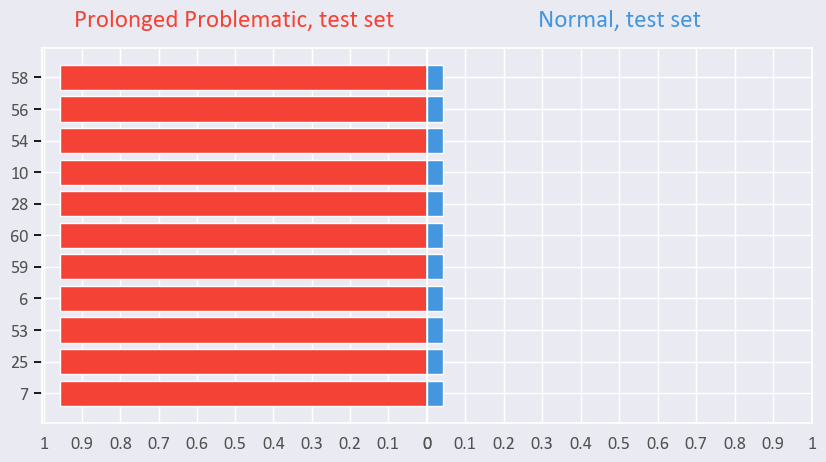

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
sns.set()

cow_id = X_test.index.copy()
cow_id = cow_id.astype(str)

font_color = '#525252'
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'
color_red = '#f44336'
color_blue = '#4496df'
index = cow_id
column0 = prob_list[:, 0]
column1 = prob_list[:, 1]
title0 = 'Prolonged Problematic, test set'
title1 = 'Normal, test set'

fig, axes = plt.subplots(figsize=(10,5), facecolor=facecolor, ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(index, column0, align='center', color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15, color=color_red, **hfont)
axes[1].barh(index, column1, align='center', color=color_blue, zorder=10)
axes[1].set_title(title1, fontsize=18, pad=15, color=color_blue, **hfont)

# If you have positive numbers and want to invert the x-axis of the left plot
axes[0].invert_xaxis() 

# To show data from highest to lowest
plt.gca().invert_yaxis()

axes[0].set(yticks=cow_id, yticklabels=cow_id)
axes[0].yaxis.tick_left()
axes[0].tick_params(axis='y', colors='black') # tick color

axes[0].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
axes[0].set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
axes[1].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
axes[1].set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)
for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)

plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)
filename = 'Prolonged_Problematic_Cows'
plt.savefig(filename+'.png', facecolor=facecolor)